# Ensemble classification model in earthquake building damage level detection

# Importing Libraries

In [ ]:
!pip install xgboost
!pip install catboost
!pip install imbalanced-ensemble
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 24 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 268 kB 43.4 MB/s 
     |████████████████████████████████| 11.2 MB 95.8 MB/s 
     |████████████████████████████████| 960 kB 95.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 681 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import cv2

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from google.colab import drive

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

# Data Loading

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/train_values.csv", index_col='building_id')

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Y= pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/train_labels.csv", index_col='building_id')

In [ ]:
Y.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [ ]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/test_values.csv", index_col='building_id')

In [ ]:
test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering: foundation_type + roof_type | 0.7506

In [ ]:
X["f_r"] = X.foundation_type + X.roof_type
test["f_r"] = test.foundation_type + test.roof_type

In [ ]:
X = X.drop(["foundation_type","roof_type"], axis=1)

In [ ]:
test = test.drop(["foundation_type","roof_type"], axis=1)

In [ ]:
import category_encoders as ce

encoder = ce.OneHotEncoder(cols=['f_r'])
encoder.fit(X, Y)

X = encoder.transform(X)
test = encoder.transform(test)

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,ground_floor_type,other_floor_type,...,f_r_5,f_r_6,f_r_7,f_r_8,f_r_9,f_r_10,f_r_11,f_r_12,f_r_13,f_r_14
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,f,q,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,x,q,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,f,x,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,f,x,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,f,x,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,ground_floor_type,other_floor_type,...,f_r_5,f_r_6,f_r_7,f_r_8,f_r_9,f_r_10,f_r_11,f_r_12,f_r_13,f_r_14
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,f,q,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,f,q,...,0,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,f,q,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,v,j,...,0,0,0,0,0,1,0,0,0,0
421793,17,289,7970,3,15,8,7,t,f,q,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering: area_percentage x and / height_percentage - 0.7494 | 0.7504

In [ ]:
X["adh"] = X.area_percentage / X.height_percentage

In [ ]:
test["adh"] = test.area_percentage / test.height_percentage

In [ ]:
#X["axh"] = X.area_percentage * X.height_percentage

In [ ]:
X = X.drop(["area_percentage","height_percentage"], axis=1)

In [ ]:
#test["axh"] = test.area_percentage * test.height_percentage

In [ ]:
test = test.drop(["area_percentage","height_percentage"], axis=1)

# Feature Engineering: SumEncoder | 0.7505

In [ ]:
import category_encoders as ce

encoder = ce.SumEncoder(cols=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'])
encoder.fit(X, Y)

X = encoder.transform(X)
test = encoder.transform(test)

/usr/local/lib/python3.7/dist-packages/category_encoders/base_contrast_encoder.py:127: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  category=FutureWarning)


In [ ]:
X.head()

,intercept,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition_0,land_surface_condition_1,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,1,6,487,12198,2,30,6,5,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
28830,1,8,900,2812,2,10,8,7,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
94947,1,21,363,8973,2,10,5,5,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
590882,1,22,418,10694,2,10,6,5,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
201944,1,11,131,1488,3,30,8,9,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,intercept,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition_0,land_surface_condition_1,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,1,17,596,11307,3,20,7,6,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
99355,1,6,141,11987,2,25,13,5,1.0,0.0,...,1,0,0,0,0,0,0,0,0,0
890251,1,22,19,10044,2,5,4,5,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
745817,1,26,39,633,1,0,19,3,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
421793,1,17,289,7970,3,15,8,7,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering: HashingEncoder | 0.7500

In [ ]:
import category_encoders as ce

encoder = ce.HashingEncoder(cols=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'])
encoder.fit(X, Y)

X = encoder.transform(X)
test = encoder.transform(test)

In [ ]:
X.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,geo_level_1_id,geo_level_2_id,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,0,2,1,0,0,2,2,1,6,487,...,0,0,0,0,0,0,0,0,0,0
28830,0,2,1,0,2,2,1,0,8,900,...,0,0,0,0,0,0,0,0,0,0
94947,0,2,1,0,0,1,3,1,21,363,...,0,0,0,0,0,0,0,0,0,0
590882,0,2,1,0,1,1,2,1,22,418,...,0,0,0,0,0,0,0,0,0,0
201944,0,2,1,0,1,1,2,1,11,131,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,geo_level_1_id,geo_level_2_id,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,0,2,1,0,1,2,1,1,17,596,...,0,0,0,0,0,0,0,0,0,0
99355,0,2,1,0,1,2,1,1,6,141,...,1,0,0,0,0,0,0,0,0,0
890251,0,2,1,0,1,2,1,1,22,19,...,0,0,0,0,0,0,0,0,0,0
745817,0,1,2,0,0,2,3,0,26,39,...,0,0,1,0,0,0,0,0,0,0
421793,0,1,1,0,0,3,2,1,17,289,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering: CountEncoder | 0.7509

In [ ]:
import category_encoders as ce

encoder = ce.CountEncoder(cols=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'])
encoder.fit(X, Y)

X = encoder.transform(X)
test = encoder.transform(test)

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,216757,219196,182842,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,8316,219196,182842,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,216757,219196,182842,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,216757,219196,182842,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,216757,219196,182842,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,216757,219196,182842,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,216757,219196,182842,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,216757,219196,182842,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,216757,219196,16183,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,216757,219196,61576,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering: GLMMEncoder | 0.7508

In [ ]:
import category_encoders as ce

encoder = ce.GLMMEncoder(cols=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'])
encoder.fit(X, Y)

X = encoder.transform(X)
test = encoder.transform(test)

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,-0.024048,0.412956,0.215602,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,0.030859,0.412956,0.215602,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,-0.024048,0.412956,0.215602,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,-0.024048,0.412956,0.215602,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,-0.024048,0.412956,0.215602,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,-0.024048,0.412956,0.215602,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,-0.024048,0.412956,0.215602,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,-0.024048,0.412956,0.215602,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,-0.024048,0.412956,-0.481737,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,-0.024048,0.412956,0.266135,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering: OrdinalEncoder | 0.7503

In [ ]:
import category_encoders as ce

encoder = ce.OrdinalEncoder(cols=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'])
encoder.fit(X, Y)

X = encoder.transform(X)
test = encoder.transform(test)

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,1,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,2,1,1,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,1,1,1,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,1,1,1,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,1,1,1,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,1,1,1,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,1,1,3,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,1,1,2,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering : Catboost Encoder - 0.7504

In [ ]:
import category_encoders as ce

encoder = ce.CatBoostEncoder(cols=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'])
encoder.fit(X, Y)

X = encoder.transform(X)
test = encoder.transform(test)

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,2.234170,2.329572,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,2.289075,2.329572,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,2.234170,2.329572,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,2.234170,2.329572,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,2.234170,2.329572,n,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,2.23417,2.329572,n,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,2.23417,2.329572,n,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,2.23417,2.329572,n,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,2.23417,2.329572,x,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,2.23417,2.329572,q,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering : One hot encode - 0.7513

In [ ]:
import category_encoders as ce

encoder = ce.OneHotEncoder(cols=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'])
encoder.fit(X, Y)

X = encoder.transform(X)
test = encoder.transform(test)

# Feature Engineering : Binning - Não deu um desempenho bom :  0.7495 | 0.7491

In [ ]:
X.age.describe()

count    260601.000000
mean         26.535029
std          73.565937
min           0.000000
25%          10.000000
50%          15.000000
75%          30.000000
max         995.000000
Name: age, dtype: float64

In [ ]:
def age_rename (age_list):
  age_rename = []

  for age in age_list:
    if age <= age_list.quantile(0.25):
      age_rename.append(0)
    elif age > age_list.quantile(0.25) and age <= age_list.quantile(0.5):
      age_rename.append(1)
    elif age > age_list.quantile(0.5) and age <= age_list.quantile(0.75):
      age_rename.append(2)
    elif age > age_list.quantile(0.75):
      age_rename.append(3)

  return age_rename

In [ ]:
#X_age = age_rename(X.age)
#X['age'] = X_age
#test_age = age_rename(test.age)
#test['age'] = test_age

# Feature Engineering : Conditional Probabilities of geo_levels

#### ID-1

In [ ]:
fea = pd.merge(X, Y, on='building_id')

In [ ]:
#this block of code calculates the probabilities
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in (X['geo_level_1_id'].value_counts()).iteritems():
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_1_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_1_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_1_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# this block of code appends a new column/feature of probabilities
list1 = []
list2 = []
list3 = []

for i in X['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo1'] = list1
X['prob2_geo1'] = list2
X['prob3_geo1'] = list3

In [ ]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo1'] = list1
test['prob2_geo1'] = list2
test['prob3_geo1'] = list3

#### ID-2

In [ ]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_2_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_2_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_2_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_2_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [ ]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo2'] = list1
X['prob2_geo2'] = list2
X['prob3_geo2'] = list3

In [ ]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo2'] = list1
test['prob2_geo2'] = list2
test['prob3_geo2'] = list3

#### ID-3

In [ ]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_3_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_3_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_3_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_3_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [ ]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo3'] = list1
X['prob2_geo3'] = list2
X['prob3_geo3'] = list3

In [ ]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo3'] = list1
test['prob2_geo3'] = list2
test['prob3_geo3'] = list3

# Feature Engineering: Finding relation between geo_levels using seq_to_seq method (LSTM)

<font size=2> **Below is just an example to show how the geo_levels might be related in some way to each other.**
**For geo_level_1 = 6 and geo_level_2=487 we see there are a lot of same geo_levels-3 indicating that there is some relation between these levels.**</font>

In [ ]:
pd.DataFrame(X['geo_level_3_id'][X['geo_level_2_id']==487][X['geo_level_1_id']==6]).head(50)

,geo_level_3_id
building_id,
802906,12198
959468,12198
410679,7439
423950,7439
215003,12198
594969,835
695349,2908
869506,7439
141511,382


### Converting the geo_levels 1 and 2 into one hot encoder with shared vocabulary

In [ ]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']])
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']])
l3 = pd.concat([X['geo_level_3_id'], test['geo_level_3_id']])

In [ ]:
#get shared vocab of l1 and l2
inp = pd.concat([l1,l2]).to_numpy().reshape(-1,1)

In [ ]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']]).to_numpy().reshape(-1,1)

In [ ]:
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']]).to_numpy().reshape(-1,1)

In [ ]:
onehot = OneHotEncoder(sparse=False)

In [ ]:
onehot.fit(inp)

OneHotEncoder(sparse=False)

In [ ]:
inp.shape

(694938, 1)

In [ ]:
onehot.categories_

[array([   0,    1,    2, ..., 1425, 1426, 1427])]

In [ ]:
l1_hot = onehot.transform(l1)

In [ ]:
l1_hot.shape

(347469, 1419)

In [ ]:
l2_hot = onehot.transform(l2)

In [ ]:
l2_hot.shape

(347469, 1419)

In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(347469, 2, 1419)

### Converting geo_level_3 into onehot

In [ ]:
l3_hot = np.array(pd.get_dummies(l3))

In [ ]:
l3_hot.shape

(347469, 11861)

### Creating a LSTM model to get relation features.

In [ ]:
inpx = Input( shape=fin_inp.shape[1:] )  

lstm = LSTM(16, )(inpx)

lvl3 = Dense(l3_hot.shape[1], activation='sigmoid')(lstm)

modelf = Model(inputs= inpx, outputs=lvl3)

modelf.compile(loss='binary_crossentropy', optimizer='adam')

modelf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 1419)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                91904     
                                                                 
 dense (Dense)               (None, 11861)             201637    
                                                                 
Total params: 293,541
Trainable params: 293,541
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelf.fit(fin_inp, l3_hot, epochs=30, batch_size=128)

Epoch 1/30
2715/2715 [==============================] - 20s 5ms/step - loss: 0.0401
Epoch 2/30
2715/2715 [==============================] - 12s 5ms/step - loss: 9.6853e-04
Epoch 3/30
2715/2715 [==============================] - 12s 5ms/step - loss: 8.4820e-04
Epoch 4/30
2715/2715 [==============================] - 12s 5ms/step - loss: 8.3361e-04
Epoch 5/30
2715/2715 [==============================] - 12s 5ms/step - loss: 8.3093e-04
Epoch 6/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.3015e-04
Epoch 7/30
2715/2715 [==============================] - 12s 5ms/step - loss: 8.2985e-04
Epoch 8/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.2970e-04
Epoch 9/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.2964e-04
Epoch 10/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.2957e-04
Epoch 11/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.2945e-04
Epoch 12/30
2715/2715 [===========

### Getting the relation vector from the output of intermediate layer

In [ ]:
inter = Model(inputs=modelf.input, outputs=modelf.layers[1].output)

<font size=3>**Train**</font>

In [ ]:
l1 = X['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = X['geo_level_2_id'].to_numpy().reshape(-1,1)

In [ ]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)

In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(260601, 2, 1419)

In [ ]:
geo_fea_train = inter.predict(fin_inp)

8144/8144 [==============================] - 12s 1ms/step


<font size=3>**Test**</font>

In [ ]:
l1 = test['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = test['geo_level_2_id'].to_numpy().reshape(-1,1)

In [ ]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(86868, 2, 1419)

In [ ]:
geo_fea_test = inter.predict(fin_inp)

2715/2715 [==============================] - 4s 1ms/step


# Final  Data

In [ ]:
print("train {}, test {}  ".format(geo_fea_train.shape, geo_fea_test.shape))

train (260601, 16), test (86868, 16)  


### Preprocessing the data with pd.get_dummies and adding the relation features

In [ ]:
fx_tr = np.hstack((np.array(pd.get_dummies(X.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))),
                   geo_fea_train))

In [ ]:
fx_tr

array([[ 2.        , 30.        ,  6.        , ..., -0.96332109,
        -0.9634248 ,  0.96268898],
       [ 2.        , 10.        ,  8.        , ..., -0.96316975,
         0.96184289,  0.96293294],
       [ 2.        , 10.        ,  5.        , ..., -0.96301818,
        -0.96367574,  0.96231717],
       ...,
       [ 3.        , 55.        ,  6.        , ..., -0.96323645,
         0.95756257,  0.96260196],
       [ 2.        , 10.        , 14.        , ..., -0.96364486,
         0.96356475,  0.96340805],
       [ 3.        , 10.        ,  7.        , ..., -0.96302003,
        -0.96075171,  0.96234   ]])

In [ ]:
fx_tr.shape

(260601, 90)

In [ ]:
test.fillna(value=0, inplace=True)

In [ ]:
fx_te = np.hstack((np.array(pd.get_dummies(test.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))), geo_fea_test))

fx_te.shape

(86868, 90)

In [ ]:
fy_tr = Y.to_numpy().ravel()
fy_tr.shape

(260601,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fx_tr, fy_tr, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[ 3.        , 25.        ,  2.        , ..., -0.96305776,
         0.96010679, -0.95765823],
       [ 3.        , 40.        , 10.        , ..., -0.96331811,
        -0.96342915,  0.96268398],
       [ 2.        , 45.        ,  8.        , ..., -0.96303838,
         0.96216315,  0.96285552],
       ...,
       [ 3.        , 20.        , 22.        , ..., -0.96316975,
         0.96201009,  0.9629373 ],
       [ 3.        , 10.        , 11.        , ..., -0.96328104,
         0.96280891, -0.96336603],
       [ 2.        ,  0.        ,  7.        , ..., -0.96303242,
         0.96211535,  0.96285498]])

# Research hyperparameters

In [ ]:
#input best params here from randm.best_params_
modelrandonforest = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

modelrandonforest = GridSearchCV(estimator=modelrandonforest, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelrandonforest.fit(X_train,y_train)

predsrandon=modelrandonforest.predict(X_test)

#f1 score is the metric used in the competition
accuracy1=f1_score(y_test,predsrandon,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
[CV 1/2; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 1/2; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.729 total time=  14.8s
[CV 2/2; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 2/2; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.728 total time=  14.8s
[CV 1/2; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500
[CV 1/2; 2/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.730 total time=  37.1s
[CV 2/2; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500
[CV 2/2; 2/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.729 total time=  37.0s
[CV 1/2; 3/60] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200
[CV 1/2; 3/60] END criterion=gini, max_d

In [ ]:
modelrandonforest.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [ ]:
#input best params here from randm.best_params_
modellgb = lgb.LGBMClassifier(random_seed=42, silent=True)

parameters = {
    'n_estimators': [100],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}
modellgb = GridSearchCV(estimator=modellgb, param_grid = parameters,cv = 2, scoring='f1_micro', verbose=10)
modellgb.fit(X_train,y_train)

predsllgb=modellgb.predict(X_test)


#f1 score is the metric used in the competition
accuracy1=f1_score(y_test,predsllgb,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 972 candidates, totalling 1944 fits
[CV 1/2; 1/972] START colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20
[CV 1/2; 1/972] END colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20;, score=0.760 total time=   3.3s
[CV 2/2; 1/972] START colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20
[CV 2/2; 1/972] END colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20;, score=0.761 total time=   3.3s
[CV 1/2; 2/972] START colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.8, subsample_freq=20

In [ ]:
modellgb.best_params_

{'colsample_bytree': 0.8,
 'max_depth': 25,
 'min_split_gain': 0.3,
 'n_estimators': 100,
 'num_leaves': 50,
 'reg_alpha': 1.1,
 'reg_lambda': 1.2,
 'subsample': 0.9,
 'subsample_freq': 20}

In [ ]:
#input best params here from randm.best_params_
modelextratrees = ExtraTreesClassifier(random_state=42)

param_grid = {  
    "n_estimators": [360,500],
    "max_depth": [4,5,6,7,8,25,30,32] 
}

modelextratrees = GridSearchCV(estimator=modelextratrees, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelextratrees.fit(X_train,y_train)

predsextra=modelextratrees.predict(X_test)

#f1 score is the metric used in the competition
accuracy1=f1_score(y_test,predsextra,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2; 1/16] START max_depth=4, n_estimators=360..............................
[CV 1/2; 1/16] END max_depth=4, n_estimators=360;, score=0.720 total time=  24.6s
[CV 2/2; 1/16] START max_depth=4, n_estimators=360..............................
[CV 2/2; 1/16] END max_depth=4, n_estimators=360;, score=0.717 total time=  25.7s
[CV 1/2; 2/16] START max_depth=4, n_estimators=500..............................
[CV 1/2; 2/16] END max_depth=4, n_estimators=500;, score=0.719 total time=  34.2s
[CV 2/2; 2/16] START max_depth=4, n_estimators=500..............................
[CV 2/2; 2/16] END max_depth=4, n_estimators=500;, score=0.718 total time=  34.2s
[CV 1/2; 3/16] START max_depth=5, n_estimators=360..............................
[CV 1/2; 3/16] END max_depth=5, n_estimators=360;, score=0.728 total time=  29.0s
[CV 2/2; 3/16] START max_depth=5, n_estimators=360..............................
[CV 2/2; 3/16] END max_depth=5, n_estimator

In [ ]:
modelextratrees.best_params_

{'max_depth': 25, 'n_estimators': 360}

In [ ]:
modelgradient = GradientBoostingClassifier(random_state=42)

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618,0.85],
    "n_estimators":[200,400]
    }

modelgradient = GridSearchCV(estimator=modelgradient, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelgradient.fit(X_train,y_train)

predsgradient=modelgradient.predict(X_test)

#f1 score is the metric used in the competition
accuracy1=f1_score(y_test,predsgradient,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
[CV 1/2; 1/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5
[CV 1/2; 1/144] END learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5;, score=0.731 total time=  39.6s
[CV 2/2; 1/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5
[CV 2/2; 1/144] END learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5;, score=0.729 total time=  39.8s
[CV 1/2; 2/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.618
[CV 1/2; 2/144] END learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.618;, score=0.731 total time=  43.0s
[CV 2/2; 2/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsamp

In [ ]:
modelgradient.best_params_

{'learning_rate': 0.025,
 'loss': 'deviance',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 400,
 'subsample': 0.618}

In [ ]:
modelada = AdaBoostClassifier(random_state=42)

param_grid = {
    "algorithm":["SAMME","SAMME.R"],
    "learning_rate": [0.01, 0.025, 0.15, 0.2],
    "n_estimators":[200,400, 500, 1000]
    }

modelada = GridSearchCV(estimator=modelada, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelada.fit(fx_tr,fy_tr)

#pred
predsada=modelada.predict(fx_tr)

#f1 score is the metric used in the competition
f1_ada=f1_score(fy_tr,predsada,average='micro')
print("F1 score from Ada Boost: ",f1_ada)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV 1/2; 1/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=200......
[CV 1/2; 1/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=200;, score=0.714 total time= 1.1min
[CV 2/2; 1/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=200......
[CV 2/2; 1/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=200;, score=0.714 total time= 1.1min
[CV 1/2; 2/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=400......
[CV 1/2; 2/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=400;, score=0.712 total time= 2.2min
[CV 2/2; 2/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=400......
[CV 2/2; 2/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=400;, score=0.713 total time= 2.2min
[CV 1/2; 3/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=500......
[CV 1/2; 3/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=500;, score=0.713 total time= 2.8min
[CV 

In [ ]:
modelada.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.15, 'n_estimators': 500}

# Applying machine learning

In [ ]:
#fitting
rf = DecisionTreeClassifier(random_state=42,criterion='entropy', max_depth=8, max_features='auto')
rf.fit(X_train,y_train)

#pred
predrf=rf.predict(X_test)

#f1 score is the metric used in the competition
f1_random=f1_score(y_test,predrf,average='micro')
print("F1 score from Random Forest: ",f1_random)

F1 score from Random Forest:  0.713282554056906


In [ ]:
X_train

array([[ 3.        , 25.        ,  2.        , ..., -0.96305776,
         0.96010679, -0.95765823],
       [ 3.        , 40.        , 10.        , ..., -0.96331811,
        -0.96342915,  0.96268398],
       [ 2.        , 45.        ,  8.        , ..., -0.96303838,
         0.96216315,  0.96285552],
       ...,
       [ 3.        , 20.        , 22.        , ..., -0.96316975,
         0.96201009,  0.9629373 ],
       [ 3.        , 10.        , 11.        , ..., -0.96328104,
         0.96280891, -0.96336603],
       [ 2.        ,  0.        ,  7.        , ..., -0.96303242,
         0.96211535,  0.96285498]])

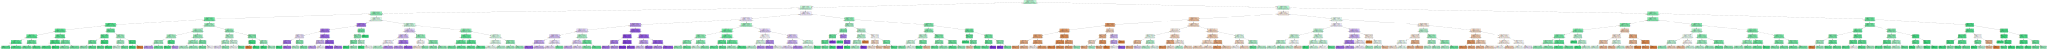

In [ ]:
import graphviz
from sklearn import tree

# DOT data
dot_data = tree.export_graphviz(rf, out_file=None,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [ ]:
#Entender onde eu estou errando mais e analisar arvore com as features
#Existem features que estão sendo muito quebradas?

In [ ]:
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.7-py3-none-any.whl size=68151 sha256=99f0c24db5dbeecc6c60cbe8f471fbbebda491359485a832af8c05dff1830907
  Stored in directory: /root/.cache/pip/wheels/bf/ba/9f/87c689d8d3c2916793f2dccc57d3dc3b283e0ccf8cb4ca4cad
Successfully built dtreeviz


In [ ]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(rf, X_train, y_train)

viz

ImportError: ignored

ImportError: ignored

<Figure size 72x72 with 1 Axes>

In [ ]:
#fitting
rf = RandomForestClassifier(random_state=42,criterion='entropy', max_depth=8, max_features='auto', n_estimators=200)
rf.fit(fx_tr,fy_tr)

#pred
predrf=rf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_random=f1_score(fy_tr,predrf,average='micro')
print("F1 score from Random Forest: ",f1_random)

F1 score from Random Forest:  0.7485120931999494


In [ ]:
#fitting
modellgb_1 = lgb.LGBMClassifier(colsample_bytree=0.7, max_depth=25, min_split_gain=0.3,
               num_leaves=200, random_seed=42, reg_alpha=1.3, reg_lambda=1.1,
               subsample=0.9, subsample_freq=20)
modellgb_1.fit(fx_tr,fy_tr)

#pred
predslgb = modellgb_1.predict(fx_tr)

#f1 score is the metric used in the competition
f1_lgb=f1_score(fy_tr,predslgb,average='micro')
print("F1 score from LGBM: ",f1_lgb)

F1 score from LGBM:  0.7891374169707716


In [ ]:
#fitting
modelextratrees = ExtraTreesClassifier(random_state=42, max_depth = 25, n_estimators = 500)
modelextratrees.fit(fx_tr,fy_tr)

#pred
predsextra=modelextratrees.predict(fx_tr)

#f1 score is the metric used in the competition
f1_extra = f1_score(fy_tr,predsextra,average='micro')
print("F1 score from Extratrees: ",f1_extra)

F1 score from Extratrees:  0.8930740864386553


In [ ]:
#fitting
modelxgb_cl = xgb.XGBClassifier(random_state=42,objective='multi:softmax', gamma=0.001369048068388758, eta=0.11,
                  max_depth= 20,
                  min_child_weight=9,
                  num_class= 4,
                  subsample= .85,
                  colsample_bytree= .9, verbose=10)
modelxgb_cl.fit(fx_tr,fy_tr)

#pred
predsxgb_cl = modelxgb_cl.predict(fx_tr)

#f1 score is the metric used in the competition
f1_xgb=f1_score(fy_tr,predsxgb_cl,average='micro')
print("F1 score from XGB: ",f1_xgb)

F1 score from XGB:  0.8694172317067087


In [ ]:
#fitting
modelgradient = GradientBoostingClassifier(random_state=42, learning_rate=0.15,loss='deviance', max_depth=8, max_features='sqrt',n_estimators= 400,subsample=0.85)
modelgradient.fit(fx_tr,fy_tr)

#pred
predsgradient = modelgradient.predict(fx_tr)

#f1 score is the metric used in the competition
f1_gradient=f1_score(fy_tr,predsgradient,average='micro')
print("F1 score from Gradient Boosting: ",f1_gradient)

F1 score from Gradient Boosting:  0.8344250405792764


In [ ]:
#fitting
modelcat = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, silent=True, border_count=13, depth= 10, iterations = 5000, l2_leaf_reg = 3, learning_rate = 0.05)
modelcat.fit(fx_tr,fy_tr)

#pred
predscat=modelcat.predict(fx_tr)

#f1 score is the metric used in the competition
f1_cat=f1_score(fy_tr,predscat,average='micro')
print("F1 score from Cat Boost: ",f1_cat)

F1 score from Cat Boost:  0.89003879493939


In [ ]:
#fitting
modelada = AdaBoostClassifier(random_state=42,base_estimator=None, learning_rate=0.4, n_estimators=190)
modelada.fit(fx_tr,fy_tr)

#pred
predsada=modelada.predict(fx_tr)

#f1 score is the metric used in the competition
f1_ada=f1_score(fy_tr,predsada,average='micro')
print("F1 score from Ada Boost: ",f1_ada)

F1 score from Ada Boost:  0.7522457703539127


In [ ]:
from imbalanced_ensemble.ensemble import AsymBoostClassifier

#fitting
AsymBoost = AsymBoostClassifier(random_state=42)
AsymBoost.fit(X_train,y_train,train_verbose=True,eval_metrics={'micro_f1': (f1_score, {'average': 'micro'})})

#pred
predAsymBoost=AsymBoost.predict(X_test)

#f1 score is the metric used in the competition
f1_AsymBoost=f1_score(y_test,predAsymBoost,average='micro')
print("F1 score from AsymBoost: ",f1_AsymBoost)

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃             ┃                                 ┃ Data: train ┃
┃ #Estimators ┃       Class Distribution        ┃   Metric    ┃
┃             ┃                                 ┃  micro_f1   ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━┫
┃      1      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.716     ┃
┃      5      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.726     ┃
┃     10      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.732     ┃
┃     15      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.734     ┃
┃     20      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.740     ┃
┃     25      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.739     ┃
┃     30      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.738     ┃
┃     35      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.738     ┃
┃     40      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.739     ┃
┃     45      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.737     ┃
┃     50      ┃ {1: 19954, 2: 118772, 3:

In [ ]:
#fitting
AsymBoost = AsymBoostClassifier(random_state=42)
AsymBoost.fit(fx_tr,fy_tr,train_verbose=True,eval_metrics={'micro_f1': (f1_score, {'average': 'micro'})})

#pred
predAsymBoost=AsymBoost.predict(fx_tr)

#f1 score is the metric used in the competition
f1_AsymBoost=f1_score(fy_tr,predAsymBoost,average='micro')
print("F1 score from AsymBoost: ",f1_AsymBoost)

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃             ┃                                 ┃ Data: train ┃
┃ #Estimators ┃       Class Distribution        ┃   Metric    ┃
┃             ┃                                 ┃  micro_f1   ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━┫
┃      1      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.715     ┃
┃      5      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.726     ┃
┃     10      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.725     ┃
┃     15      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.728     ┃
┃     20      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.739     ┃
┃     25      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.740     ┃
┃     30      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.736     ┃
┃     35      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.737     ┃
┃     40      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.737     ┃
┃     45      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.736     ┃
┃     50      ┃ {1: 25124, 2: 148259, 3:

# Ensemble Classifier - Voting Classifier

In [ ]:
%%time

voting_clf = VotingClassifier(estimators=[('rf', rf),
                                          ('lgb',modellgb_1),
                                          ('gradient',modelgradient),
                                          ('extra',modelextratrees),
                                          ('xbg', modelxgb_cl),
                                          ('cat', modelcat),
                                          ('ada', modelada),
                                          ('AB', AsymBoost)], voting='soft', verbose=10)
voting_clf.fit(fx_tr,fy_tr)

#pred
pred_votting = voting_clf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_votting = f1_score(fy_tr,pred_votting,average='micro')

print("F1 score from Votting: ",f1_votting) #

[Voting] ....................... (1 of 8) Processing rf, total=  50.0s
[Voting] ...................... (2 of 8) Processing lgb, total=  32.4s
[Voting] ................. (3 of 8) Processing gradient, total=10.1min
[Voting] .................... (4 of 8) Processing extra, total= 4.8min
[Voting] ...................... (5 of 8) Processing xbg, total=22.3min
[Voting] ...................... (6 of 8) Processing cat, total=15.5min
[Voting] ...................... (7 of 8) Processing ada, total= 2.1min
[Voting] ....................... (8 of 8) Processing AB, total=  39.7s
F1 score from Votting:  0.8536421579349274
CPU times: user 2h 17min 43s, sys: 48.8 s, total: 2h 18min 32s
Wall time: 58min 53s


In [ ]:
pred_votting_base_test = voting_clf.predict(fx_te)

sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/r_f.csv", index=False) 

# Evaluations

In [ ]:
probas = [c.predict_proba(fx_tr) for c in (rf, modellgb, modelgradient, modelextratrees, modelxgb_cl, voting_clf)]

In [ ]:
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]
class3_1 = [pr[0, 2] for pr in probas]

In [ ]:
df_models = pd.DataFrame(None,columns=["percent","classe"])

for n in class1_1:
  df_class1 = pd.DataFrame([[n, 'class1']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class1])

for n in class2_1:
  df_class2 = pd.DataFrame([[n, 'class2']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class2])

for n in class3_1:
  df_class3 = pd.DataFrame([[n, 'class3']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class3])

df_models["models"] = ['Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier',
                      'Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier',
                      'Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier']

df_models['percent'] = round(df_models.percent,2)

In [ ]:
df_models

,percent,classe,models
0,0.01,class1,Random Forest
0,0.00,class1,LGBM
0,0.00,class1,Gradient Boosting
0,0.00,class1,Extraa Trees
0,0.00,class1,XGB Boosting
0,0.04,class1,Votting Classifier
0,0.24,class2,Random Forest
0,0.12,class2,LGBM
0,0.15,class2,Gradient Boosting
0,0.14,class2,Extraa Trees


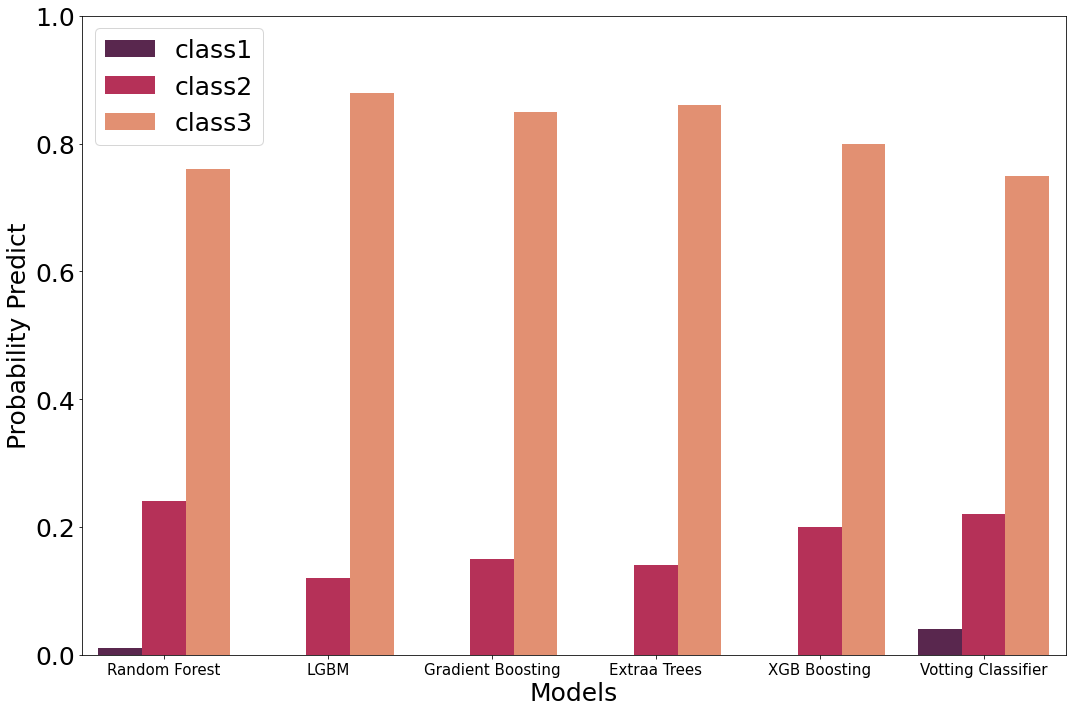

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

sns.color_palette("rocket", as_cmap=True)

sns.barplot(data=df_models, x='models', y='percent', hue='classe', palette='rocket')

plt.ylim([0, 1])
plt.legend(prop={'size': 25})
plt.ylabel('Probability Predict', size=25)
plt.xlabel('Models', size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

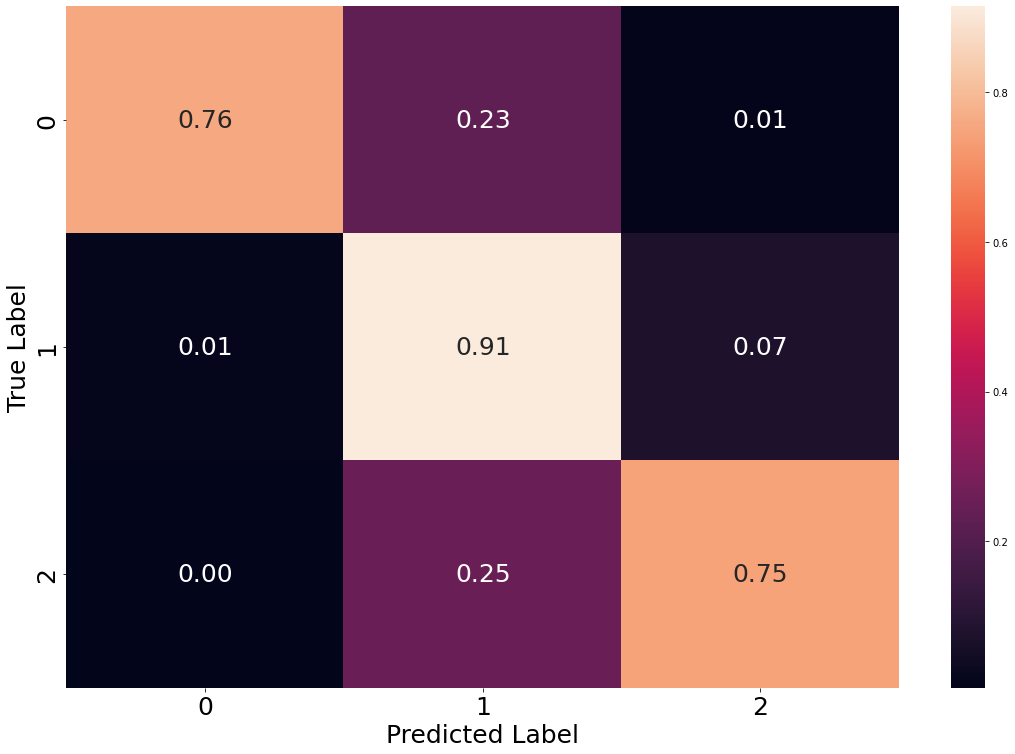

In [ ]:
cm = confusion_matrix(fy_tr, pred_votting, labels=voting_clf.classes_)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cmn, annot=True, fmt='.2f', annot_kws={'size': 25}, ax=ax)
fig.tight_layout()
plt.ylabel('True Label', size=25)
plt.xlabel('Predicted Label', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show(block=False)

# Submit

In [ ]:
pred_votting_base_test = voting_clf.predict(fx_te)

sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/class_balanced_test_8.csv", index=False)

In [ ]:
sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/ensemble_1.csv", index=False)

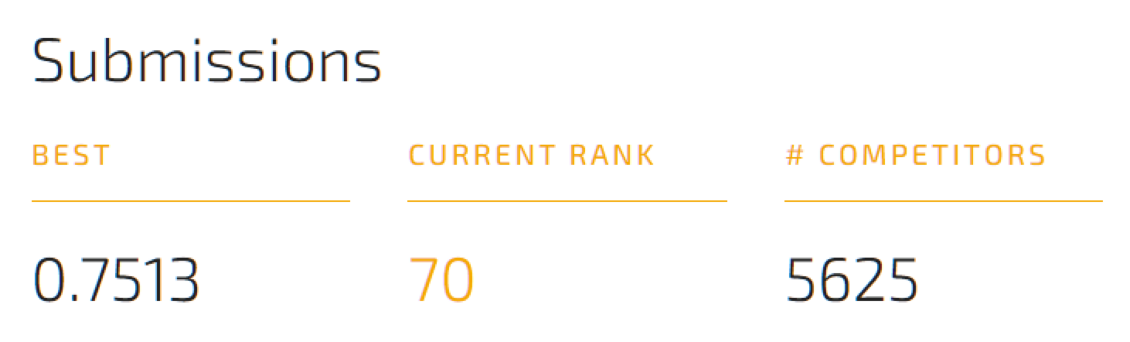

In [ ]:
img = cv2.imread("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/Results 2022-08-08.png")

plt.figure(figsize=(20, 16))
plt.imshow(img)
plt.axis('off')
plt.show()